In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
####### VAE #######
# !pip install tensorflow
# !pip3 install tf-nightly

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
import argparse
import os
import re

import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import Lambda, Input, Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras import backend as K
import soundfile as sf

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
# import eli5
# from eli5.sklearn import PermutationImportance

import pickle
import joblib

In [ ]:
# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

## wav -> feature dataframe

In [ ]:
N_FFT = 2048  # FFT window size
HOP_LENGTH = 512 # number audio of frames between STFT columns
WAV_LENGTH = 661794 # 기존 30초짜리 wav 파일의 length

col_name = ['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
            'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var',
            'rolloff_mean','rolloff_var', 'zero_crossing_rate_mean','zero_crossing_rate_var', 'harmony_mean',
            'harmony_var','perceptr_mean','perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var',
            'mfcc3_mean','mfcc3_var','mfcc4_mean', 'mfcc4_var','mfcc5_mean', 'mfcc5_var','mfcc6_mean','mfcc6_var',
            'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean',
            'mfcc10_var','mfcc11_mean','mfcc11_var','mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var',
            'mfcc14_mean','mfcc14_var','mfcc15_mean','mfcc15_var', 'mfcc16_mean','mfcc16_var', 'mfcc17_mean',
            'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var','mfcc20_mean', 'mfcc20_var']

# 30 sec
# wav 파일 하나 -> 30sec feature extraction -> dataframe
def table_arr(wav_data):
  n_li = []
  y, sr = librosa.load(wav_data)
  audio_file, _ = librosa.effects.trim(y)

  # file_name
  n_li.append(str(wav_data)[34:])   # 파일명에 따라 변경..
  # length
  n_li.append(len(audio_file))
  # chroma_stft
  chroma_stft = librosa.feature.chroma_stft(audio_file, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(chroma_stft))
  n_li.append(np.var(chroma_stft))
  # rms
  rms = librosa.feature.rms(audio_file, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(rms))
  n_li.append(np.var(rms))
  # spectral_centroid
  spec_cent = librosa.feature.spectral_centroid(audio_file, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(spec_cent))
  n_li.append(np.var(spec_cent))
  # spectral_bandwidth
  spec_bw = librosa.feature.spectral_bandwidth(audio_file, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(spec_bw))
  n_li.append(np.var(spec_bw))
  # rolloff
  rolloff = librosa.feature.spectral_rolloff(audio_file, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(rolloff))
  n_li.append(np.var(rolloff))
  # zero_crossing_rate
  zcr = librosa.feature.zero_crossing_rate(audio_file, hop_length=HOP_LENGTH).flatten()
  n_li.append(np.mean(zcr))
  n_li.append(np.var(zcr))
  # harmony
  harmony = librosa.effects.harmonic(audio_file)
  n_li.append(np.mean(harmony))
  n_li.append(np.var(harmony))
  # perceptr
  perc = librosa.effects.percussive(audio_file)
  n_li.append(np.mean(perc))
  n_li.append(np.var(perc))
  # tempo
  tempo = librosa.beat.tempo(audio_file)
  n_li.append(tempo[0])
  # mfcc
  mfccs = librosa.feature.mfcc(y=audio_file, sr=sr)
  for i in range(len(mfccs)):
    n_li.append(np.mean(mfccs[i]))
    n_li.append(np.var(mfccs[i]))
  
  return n_li

def feature_30_sec(wav_data):
  n_li = table_arr(wav_data)
  df_30 = pd.DataFrame([n_li], columns=col_name)
  return df_30


# 3 sec
# wav(30sec) -> 3sec짜리 wav로 쪼개기
def trim_audio(wav_data, y, sr):
  sec = 3   # 3초짜리
  audio_file, _ = librosa.effects.trim(y)
  
  # 기존 30초 wav보다 짧다면
  if len(audio_file) < WAV_LENGTH:  
    for i in range(9):
      ny = y[sr*sec*i:sr*sec*(i+1)]
      sf.write(str(wav_data)[:-3] + str(i) + '.wav', ny, sr)

    # 마지막 wav는 후반부 3초로
    ny = y[-sr*sec:]
    sf.write(str(wav_data)[:-3] +'9.wav', ny, sr)

  # 기존 30초 wav와 길이가 같다면
  else:
    for i in range(10):
      ny = y[sr*sec*i:sr*sec*(i+1)]
      sf.write(str(wav_data)[:-3] + str(i) + '.wav', ny, sr)

# wav 파일 하나 -> 3sec feature extraction -> dataframe
def feature_3_sec(wav_data):
  y, sr = librosa.load(wav_data)
  trim_audio(wav_data, y, sr)   # 3초짜리 10개 wav 파일로 쪼개고

  total_table = []
  for i in range(10): # 10개 파일별로 feature 추출한 리스트 -> 행으로 합치기
    # print("str(wav_data)[:-3] : ", str(wav_data)[:-3], "str(i) : ", str(i))
    li_ = table_arr(str(wav_data)[:-3] + str(i)+'.wav')
    total_table.append(li_)
    os.remove(str(wav_data)[:-3] + str(i)+'.wav') # 만들었던 3초짜리 데이터 삭제

  df_3 = pd.DataFrame(total_table, columns=col_name)
  return df_3  

# 생성 음악 파일 test

In [ ]:
def cleaning(x):
  if str(x).find("_") != -1:
    return str(x)[:-1]
  return str(x)
  
def count_1d_df(wav_file):

##############################    1D Array로 변환   #######################################

  music_count = 10
  cols = []
  for i in range(music_count):
    for j in range(len(wav_file.columns)):
      cols.append(wav_file.columns[j]+str(i))

  df = pd.DataFrame(columns=cols)
  final_cols = list(df.columns)
  # print(final_cols)

  for i in range(len(wav_file)):
    if i%10 == 0:
      if i != 0:
        temp = temp.T
        temp.columns = df.columns
        df = pd.concat([df, temp])
        df.reset_index(inplace=True, drop=True)
      temp = pd.DataFrame(wav_file.iloc[i,:])
      temp.columns = [0]
    else:
      temp = pd.concat([temp, wav_file.iloc[i,:]])
  temp = temp.T
  temp.columns = df.columns
  df = pd.concat([df, temp])  
  df.reset_index(inplace=True, drop=True)

  remove_cols = ['filename', 'length']
  for col in remove_cols:
    for i in range(10):
      if i == 0: # 첫번째는 삭제하지 않고 유지
        idx = final_cols.index(col+str(i))
        final_cols[idx] = col
      else:
        final_cols.remove(col+str(i))
        df = df.drop(columns=col+str(i))

  # print(len(final_cols))  # 3개(filename, length, label)씩 10개(장르), 총 30개 줄어듦
  df.columns = final_cols

  ##############################    PCA   #######################################

  # pca 전 열 제거
  X = df.drop(columns=['filename', 'length'])
  # X = pd.concat([X, tt])

  # 정규화
  cols = X.columns
  min_max_scaler = preprocessing.MinMaxScaler()
  np_scaled = min_max_scaler.fit_transform(X)
  X = pd.DataFrame(np_scaled, columns = cols)

  pca = PCA(n_components=30)
  pcs = pca.fit_transform(X)
  X = pd.DataFrame(data=pcs, columns = ['pc'+str(j) for j in range(30)])

  ##############################    예측    #######################################

  # 해당 분류모델 예측값
  new_pred = model.predict(X)  
  
  result_df = pd.DataFrame(columns = ['filename', 'ex_label', 'pred'])
  result_df['filename'] = df['filename']
  result_df['ex_label'] = df['filename'].str[:-6]
  result_df['pred'] = new_pred

  return result_df

In [ ]:
PATH = '/content/drive/MyDrive/기계팀플/Data/genres_generated(clean)/'
vae_path = 'vae_'

# model : nb, lg, sgd, knn, dt, rf, svm, nn, xgb, xgbrf
model = joblib.load('/content/drive/MyDrive/기계팀플/Model/knn_1d_pca30.pkl')

result_df = []  # 최종 df

In [ ]:
# # 전체 데이터 불러와서 3초로 분할 & 세로로 붙이기(총 1000개의 행)

# wav_df = pd.DataFrame()
# for filename in os.listdir(PATH):
#   wav_df = pd.concat([wav_df, feature_3_sec(PATH + filename)])  # feature dataframe

# wav_df.to_csv('/content/drive/MyDrive/기계팀플/Data/generated_all_3sec.csv', index=False)

In [ ]:
wav_df = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/generated_all_3sec.csv')

result_1d_df = count_1d_df(wav_df)

label = []
for i in range(len(result_1d_df)):
  label.append(result_1d_df['filename'].iloc[i][33:-8])

result_1d_df['ex_label'] = label
result_1d_df['ex_label'] = result_1d_df['ex_label'].apply(cleaning)

result_1d_df = result_1d_df.sort_values(by='filename', ascending=True)
result_1d_df.reset_index(inplace=True, drop=True)

result_1d_df

,filename,ex_label,pred
0,Data/genres_generated(clean)/vae_blues_1.0.wav,blues,country
1,Data/genres_generated(clean)/vae_blues_10.0.wav,blues,rock
2,Data/genres_generated(clean)/vae_blues_2.0.wav,blues,reggae
3,Data/genres_generated(clean)/vae_blues_3.0.wav,blues,reggae
4,Data/genres_generated(clean)/vae_blues_4.0.wav,blues,country
...,...,...,...
95,Data/genres_generated(clean)/vae_rock_5.0.wav,rock,pop
96,Data/genres_generated(clean)/vae_rock_6.0.wav,rock,country
97,Data/genres_generated(clean)/vae_rock_7.0.wav,rock,country
98,Data/genres_generated(clean)/vae_rock_8.0.wav,rock,disco


In [ ]:
print("라벨 일치 개수 :", len(result_1d_df[result_1d_df['ex_label'] == result_1d_df['pred']]))

result_1d_df[result_1d_df['ex_label'] == result_1d_df['pred']]

라벨 일치 개수 : 7


,filename,ex_label,pred
23,Data/genres_generated(clean)/vae_country_3.0.wav,country,country
24,Data/genres_generated(clean)/vae_country_4.0.wav,country,country
25,Data/genres_generated(clean)/vae_country_5.0.wav,country,country
27,Data/genres_generated(clean)/vae_country_7.0.wav,country,country
28,Data/genres_generated(clean)/vae_country_8.0.wav,country,country
29,Data/genres_generated(clean)/vae_country_9.0.wav,country,country
85,Data/genres_generated(clean)/vae_reggae_5.0.wav,reggae,reggae


In [ ]:
result_1d_df['ex_label'].unique()

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

In [ ]:
result_1d_df['pred'].unique()

array(['country', 'rock', 'reggae', 'disco', 'hiphop', 'pop', 'jazz',
       'blues', 'metal'], dtype=object)

In [ ]:
# result_df # wav 하나 당 행 하나

result_1d_df.to_csv('/content/drive/MyDrive/기계팀플/Data/result_knn_1d_pca30.csv',encoding='utf-8', index=False)
result_1d_df

,filename,ex_label,pred
0,Data/genres_generated(clean)/vae_blues_1.0.wav,blues,country
1,Data/genres_generated(clean)/vae_blues_10.0.wav,blues,rock
2,Data/genres_generated(clean)/vae_blues_2.0.wav,blues,reggae
3,Data/genres_generated(clean)/vae_blues_3.0.wav,blues,reggae
4,Data/genres_generated(clean)/vae_blues_4.0.wav,blues,country
...,...,...,...
95,Data/genres_generated(clean)/vae_rock_5.0.wav,rock,pop
96,Data/genres_generated(clean)/vae_rock_6.0.wav,rock,country
97,Data/genres_generated(clean)/vae_rock_7.0.wav,rock,country
98,Data/genres_generated(clean)/vae_rock_8.0.wav,rock,disco


## 외부 음악 분류 test

In [ ]:
model = joblib.load('/content/drive/MyDrive/기계팀플/Model/knn_1d_pca30.pkl')

In [ ]:
# # 외부음악 하나의 파일로 통합
# wav_df = pd.DataFrame()
# for filename in os.listdir(PATH):
#   wav_df = pd.concat([wav_df, feature_3_sec(PATH + filename)])  # feature dataframe
# wav_df.reset_index(inplace=True, drop=True)
# wav_df.to_csv('/content/drive/MyDrive/기계팀플/Data/total_외부음악.csv', index=False)

In [ ]:
array1 = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/total_외부음악.csv')
array2 = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/generated_all_3sec.csv')

# 외부 음악 수가 30개 미만이라 PCA 진행 시 오류 발생하므로 원본 데이터와 병합
wav_df = pd.concat([array1, array2])
wav_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,Data/외부음악/metal_30s.0.wav,66150,0.617246,0.047219,0.119310,0.000685,2368.849974,96542.824108,2457.576858,36070.879176,...,6.688714,23.485840,-4.592693,16.085392,4.252212,18.314562,-0.222880,17.568205,0.860276,11.520973
1,Data/외부음악/metal_30s.1.wav,66150,0.630935,0.048041,0.111958,0.000706,2438.996123,124155.423046,2418.707656,52273.923664,...,4.953018,19.920782,-5.996800,16.920494,3.991507,19.958437,1.684530,16.590450,4.402995,26.742855
2,Data/외부음악/metal_30s.2.wav,66150,0.559527,0.061976,0.111071,0.000604,2073.821054,222224.811563,2252.716222,111819.749916,...,6.281479,26.816668,-1.777453,24.530615,3.546537,33.584576,1.951643,24.650763,3.561119,33.953710
3,Data/외부음악/metal_30s.3.wav,66150,0.562937,0.061165,0.113466,0.000626,2232.085735,383443.395828,2301.727753,166227.361480,...,7.658499,44.715805,-2.771037,32.469906,2.090197,32.313385,0.498372,32.921540,1.937020,36.210575
4,Data/외부음악/metal_30s.4.wav,66150,0.573335,0.055518,0.117434,0.000700,2551.030408,164512.094406,2484.663725,48921.655924,...,3.934950,18.104944,-4.270759,24.964397,4.457735,20.727457,1.120509,17.056173,4.211462,23.906176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Data/genres_generated(clean)/vae_disco_2.5.wav,66150,0.435010,0.068601,0.115216,0.000048,538.927577,1932.056059,456.216834,597.165654,...,11.803674,8.960377,17.086193,11.431543,-0.694014,10.753747,-14.222930,9.659918,-5.844204,6.822618
996,Data/genres_generated(clean)/vae_disco_2.6.wav,66150,0.433531,0.069764,0.114904,0.000057,546.913093,2112.558209,460.175876,2044.848320,...,12.882770,10.497343,17.343435,11.786688,-1.821081,11.648297,-15.489972,11.041529,-5.837422,8.643991
997,Data/genres_generated(clean)/vae_disco_2.7.wav,66150,0.384589,0.071790,0.111558,0.000082,558.197650,4144.948073,468.091260,3571.108023,...,11.940212,10.776030,16.857903,8.317174,-1.177654,8.405025,-14.312184,10.274908,-4.964975,11.067499
998,Data/genres_generated(clean)/vae_disco_2.8.wav,66150,0.342950,0.078357,0.105916,0.000057,606.327891,1299.573424,473.256277,2952.210925,...,13.116587,9.281898,17.893608,14.798299,-0.442579,14.113461,-13.450348,17.483830,-3.816600,13.420833


In [ ]:
result_1d_df = count_1d_df(wav_df)

label = []
for i in range(len(result_1d_df)):
  label.append(result_1d_df['filename'].iloc[i][10:-10])

result_1d_df['ex_label'] = label
result_1d_df = result_1d_df.head(12)

print(len(result_1d_df[result_1d_df['ex_label'] == result_1d_df['pred']]))

result_1d_df.to_csv('/content/drive/MyDrive/기계팀플/Data/result_외부음악_knn_1d_pca30.csv', index=False)
result_1d_df

1


,filename,ex_label,pred
0,Data/외부음악/metal_30s.0.wav,metal,hiphop
1,Data/외부음악/reggae_30s.0.wav,reggae,hiphop
2,Data/외부음악/hiphop_30s.0.wav,hiphop,reggae
3,Data/외부음악/pop_30s.0.wav,pop,hiphop
4,Data/외부음악/rock_30s.0.wav,rock,jazz
5,Data/외부음악/disco_30s.0.wav,disco,disco
6,Data/외부음악/blues_30s.0.wav,blues,pop
7,Data/외부음악/classical_30s.0.wav,classical,disco
8,Data/외부음악/country_30s.0.wav,country,hiphop
9,Data/외부음악/jazz_30s.0.wav,jazz,country


# 분류 결과 시각화

In [ ]:
table = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/result_knn_1d_pca30.csv', index_col=0)
table

,ex_label,pred
filename,,
Data/genres_generated(clean)/vae_blues_1.0.wav,blues,country
Data/genres_generated(clean)/vae_blues_10.0.wav,blues,rock
Data/genres_generated(clean)/vae_blues_2.0.wav,blues,reggae
Data/genres_generated(clean)/vae_blues_3.0.wav,blues,reggae
Data/genres_generated(clean)/vae_blues_4.0.wav,blues,country
...,...,...
Data/genres_generated(clean)/vae_rock_5.0.wav,rock,pop
Data/genres_generated(clean)/vae_rock_6.0.wav,rock,country
Data/genres_generated(clean)/vae_rock_7.0.wav,rock,country


In [ ]:
table[table['ex_label'] == table['pred']]

,ex_label,pred
filename,,
Data/genres_generated(clean)/vae_country_3.0.wav,country,country
Data/genres_generated(clean)/vae_country_4.0.wav,country,country
Data/genres_generated(clean)/vae_country_5.0.wav,country,country
Data/genres_generated(clean)/vae_country_7.0.wav,country,country
Data/genres_generated(clean)/vae_country_8.0.wav,country,country
Data/genres_generated(clean)/vae_country_9.0.wav,country,country
Data/genres_generated(clean)/vae_reggae_5.0.wav,reggae,reggae


No handles with labels found to put in legend.


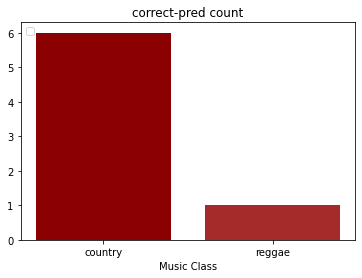

In [ ]:
colors1 = ['#8b0000', '#a52a2a', '#cd5c5c', '#f08080', '#fa8072',
          '#e9967a', '#ffa07a', '#ffdab9', '#ffe4c4', '#ffe4b5']

#제대로 분류한 애들
c2 = table[table['pred'] == table['ex_label']]
t2 = pd.DataFrame(c2['ex_label'].value_counts())
ratio2 = t2['ex_label']
labels2 = t2.index.tolist()
index2 = np.arange(0, max(ratio2)+1)

plt.bar(labels2, ratio2, color=colors1)
plt.title('correct-pred count')
plt.xlabel('Music Class')
plt.yticks(index2)
plt.legend(loc='upper left')

plt.show()

No handles with labels found to put in legend.


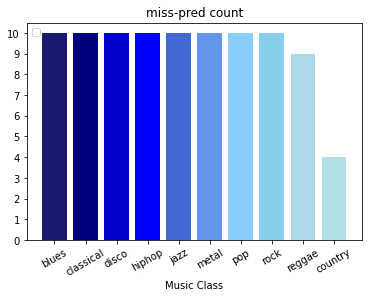

In [ ]:
colors2 = ['#191970', '#000080', '#0000cd', '#0000ff', '#4169d1',
           '#6495ed', '#87cefa', '#87ceeb', '#add8e6', '#b0e0e6']

#제대로 분류 못한 애들
c = table[table['pred'] != table['ex_label']]
tt = pd.DataFrame(c['ex_label'].value_counts())
ratio = tt['ex_label']
labels = tt.index.tolist()
index = np.arange(0, max(ratio)+1)

plt.bar(labels, ratio, color=colors2)
plt.title('miss-pred count')
plt.xlabel('Music Class')
plt.xticks(rotation=30)
plt.yticks(index)
plt.legend(loc='upper left')

plt.show()

No handles with labels found to put in legend.


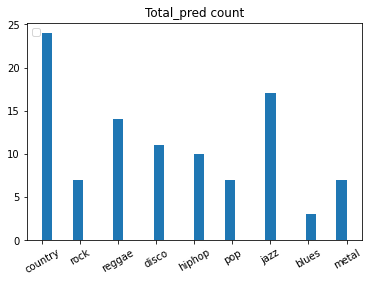

In [ ]:
# a = table['ex_label']
b = table['pred']

plt.hist(b, bins = 30)
plt.title('Total_pred count')
plt.xticks(rotation=30)
plt.legend(loc='upper left')

plt.show()